## EDA

This notebook contains the exploratory data analysis for the risk modeling project

In [1]:
import os
import sys
import yaml
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt

In [2]:
# Import yaml file in order to access global variables and paths
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
import graph_properties
from src.eda import graph_categorical, plot_panel, cap_at_95th_percentile
from src.tables import render_mpl_table

In [3]:
# Loading config file
config_name = "config.yaml"
with open(os.path.join(parent_dir, config_name), encoding="utf-8") as conf:
        config_f = yaml.safe_load(conf)

## Data

In [4]:
main = pd.read_parquet(os.path.join(config_f["data"]["data_raw"],"main_dataset.parquet"), engine='pyarrow')
credit_reports = pd.read_parquet(os.path.join(config_f["data"]["data_raw"], "credit_reports.parquet"), engine="pyarrow")

I'll join the data frames, but before doing so, I'll aggregate the variables I'm interested in from the credit_reports dataframe, considering that a customer might have multiple loans in their credit history.

In [5]:
df_total  = (credit_reports[["LOAN_ID","CUSTOMER_ID", 'BALANCE_DUE','CREDIT_LIMIT','MAX_CREDIT','CURRENT_BALANCE' ]].groupby(by=["LOAN_ID", "CUSTOMER_ID"]).mean().reset_index()\
             .merge(main, on=["LOAN_ID","CUSTOMER_ID"], how="right"))

### Distribution of the target variable
The client took 34 or more days to pay.

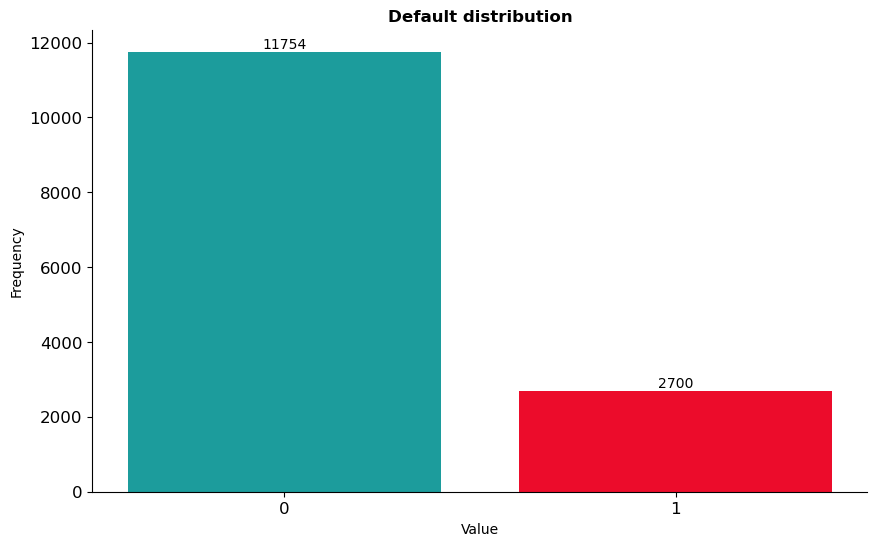

In [6]:
graph_categorical(df_total,'target','Default distribution',xticks=[0,1],figsize=(10,6))


We observe an imbalanced distribution of the classes of interest. In particular, the clients who defaulted in the set period are 2,700 and the clients who paid their contractual obligations on time are 11,754.

### Independent variables

I will begin the analysis with a reduced set of variables, trying to justify the selection of these variables to estimate the probability of default.

#### Main dataset

 - "LOAN_TYPE": The type of debt taken on might influence the likelihood of default.<br> <strong>Justification</strong>: Different types of loans might have different interest rates, payment terms, and customer profiles, which could influence default rates. <br>
 - "FINANCED_AMOUNT": The amount of debt taken could be a factor in non-payment. <br> <strong>Justification: Larger debts might imply heavier financial burdens, potentially increasing the risk of default.<br><br>
 - "account_to_application_days": The number of days that elapse between account creation and applying for a debt product might suggest whether or not the client is in a challenging financial situation, which could influence their decision to take on debt and possibly their repayment behavior. <br> <strong>Justification</strong>: Those in urgent financial needs might be more inclined to default due to their unstable financial circumstances.<br><br>
    
  - "n_sf_apps" (number of applications for smartphone financing): If a client has multiple applications for this product, depending on their repayment behavior on it, it might help predict the repayment behavior of the main credit product. <br> <strong>Justification</strong>: High frequency of specific loan applications might suggest a pattern in borrowing behavior and thus impact their repayment capacity.<br><br>
    
  - "n_bnpl_apps" (number of applications for the main credit product financing): Having made recurring applications might help predict repayment behavior because of past performance and familiarity with the product.
    
  - "n_inquiries_l3m" (inquiries to credit reports from external entities in the last 3 months): This can help predict the likelihood of default.<br> <strong> Justification</strong>: Multiple inquiries might suggest that the borrower is actively seeking credit from various sources, potentially indicating financial strain."<br><br>
    
    
In particular i'll not use "n_bnpl_approved_apps" (number of previously approved applications) since it has a strong correlation with "n_bnpl_apps".
    
#### Credit reports dataset
    
    Considering that a client might have multiple loans reflected in their credit history, I will calculate the average of the following variables, grouped by both client and loan:
    - CREDIT_LIMIT.
    - CURRENT_BALANCE.

In [7]:
categoricas = ["LOAN_TYPE","APPLICATION_DATETIME"]
numericas = ["FINANCED_AMOUNT", "account_to_application_days", "n_sf_apps", "n_bnpl_apps", "n_inquiries_l3m" ]
credit_variables = ['BALANCE_DUE','CREDIT_LIMIT','MAX_CREDIT','CURRENT_BALANCE']

#### Checking null values

In [8]:
df_total[categoricas].isna().sum()

LOAN_TYPE               0
APPLICATION_DATETIME    0
dtype: int64

In [9]:
df_total[numericas].isna().sum()

FINANCED_AMOUNT                   0
account_to_application_days       0
n_sf_apps                      7648
n_bnpl_apps                    5715
n_inquiries_l3m                5371
dtype: int64

In [10]:
df_total[credit_variables].isna().sum()

BALANCE_DUE        5282
CREDIT_LIMIT       5296
MAX_CREDIT         5283
CURRENT_BALANCE    5282
dtype: int64

From the main df only n_sf_apps, n_bnpl_apps, and n_inquiries_l3m have missing values. These null values can be replaced with zeros, as the absence of an observation in any of these three variables implies that the client has not applied for a loan in the past or has not had a credit report inquiry. Regarding the credit reports variables i'll deal with the missing values in a particular way for each trained algorithm in the following sections

In [11]:
df_total[numericas] = df_total[numericas].fillna(0)

####  Categorical variables

There is no observed variation in the types of loans registered, so I will omit this variable from the analysis.

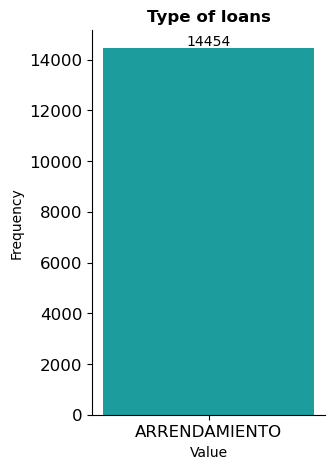

In [12]:
graph_categorical(df_total,'LOAN_TYPE','Type of loans', xticks=["ARRENDAMIENTO"],figsize=(3,5))

In [13]:
df_total = (df_total
            .assign(
             APPLICATION_MONTH=lambda df: df["APPLICATION_DATETIME"].dt.month,
             APPLICATION_YEAR=lambda df: df["APPLICATION_DATETIME"].dt.year)
)

The month with the highest number of applications is December, followed by January. It's important to note that the data for the year 2023 only includes observations up to May.

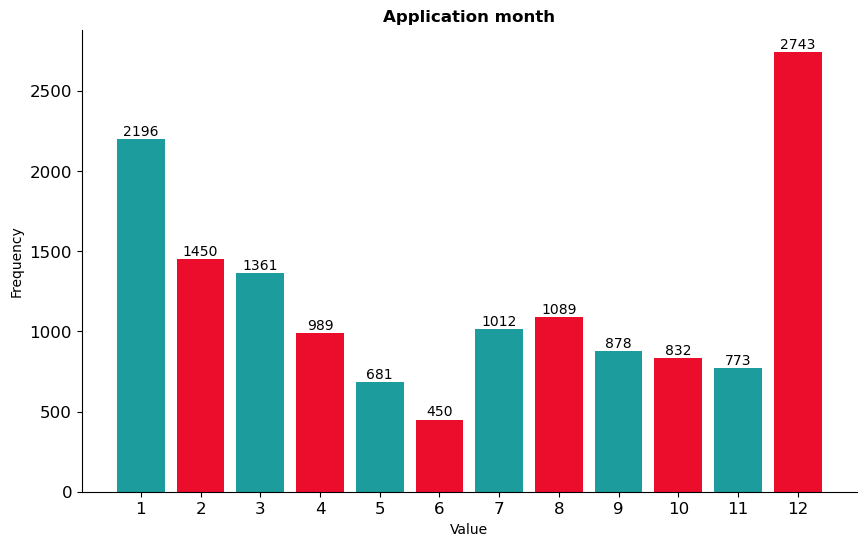

In [14]:
graph_categorical(df_total, "APPLICATION_MONTH", "Application month")

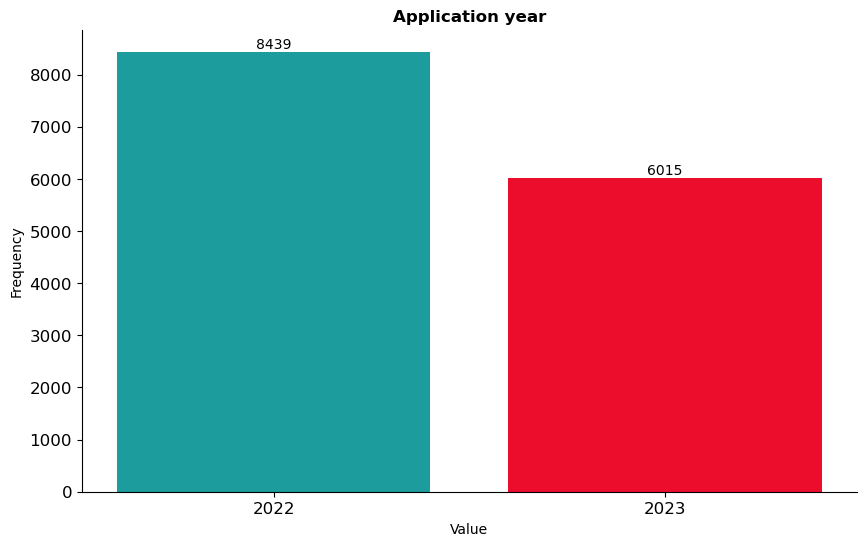

In [15]:
graph_categorical(df_total, "APPLICATION_YEAR", "Application year",xticks=[2022,2023])

#### Numerical variables

I have noticed variability in the chosen variables that are meant to serve as predictors for default probability. Consequently, I will incorporate them into the analysis.

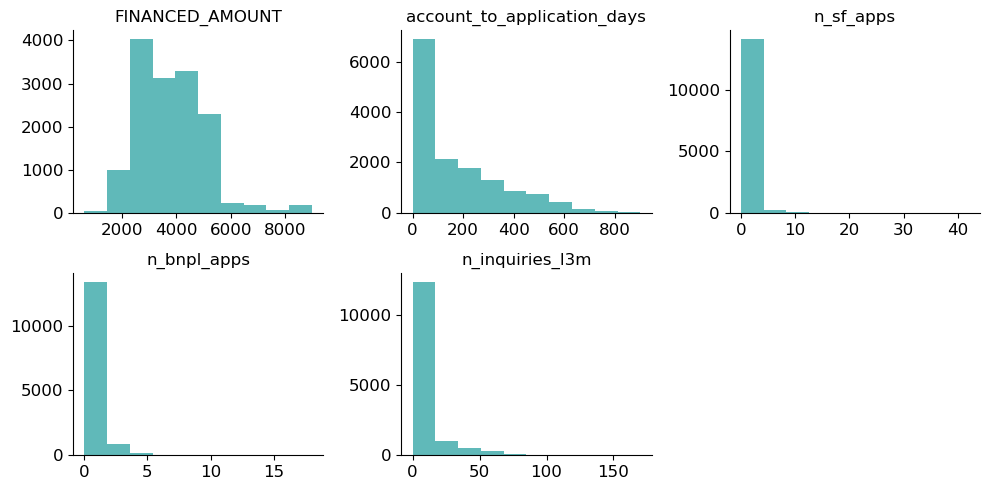

In [16]:
plot_panel(df_total, numericas, 2,3, figsize=(10,5))

In [17]:
for var in credit_variables:
    df_total = cap_at_95th_percentile(df_total, var)

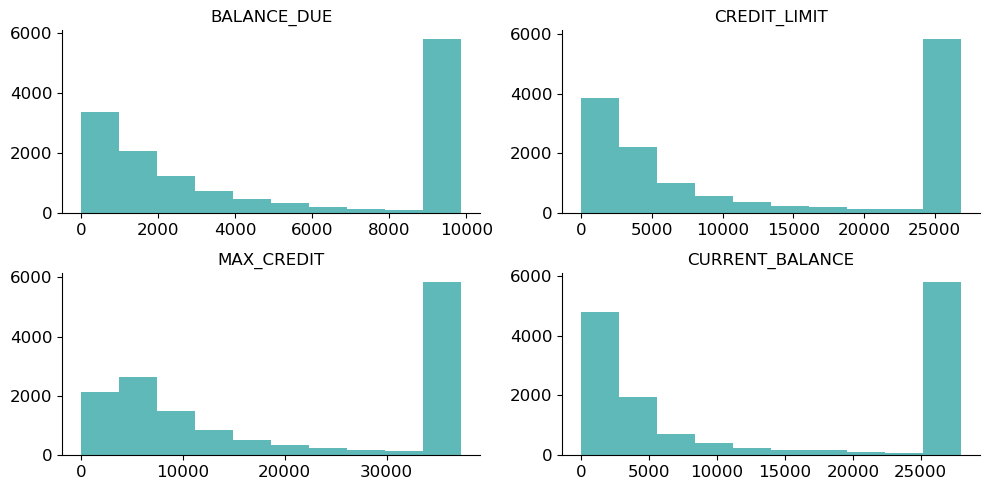

In [18]:
plot_panel(df_total, credit_variables, 2,2, figsize=(10,5))

### Observed correlation with target variable

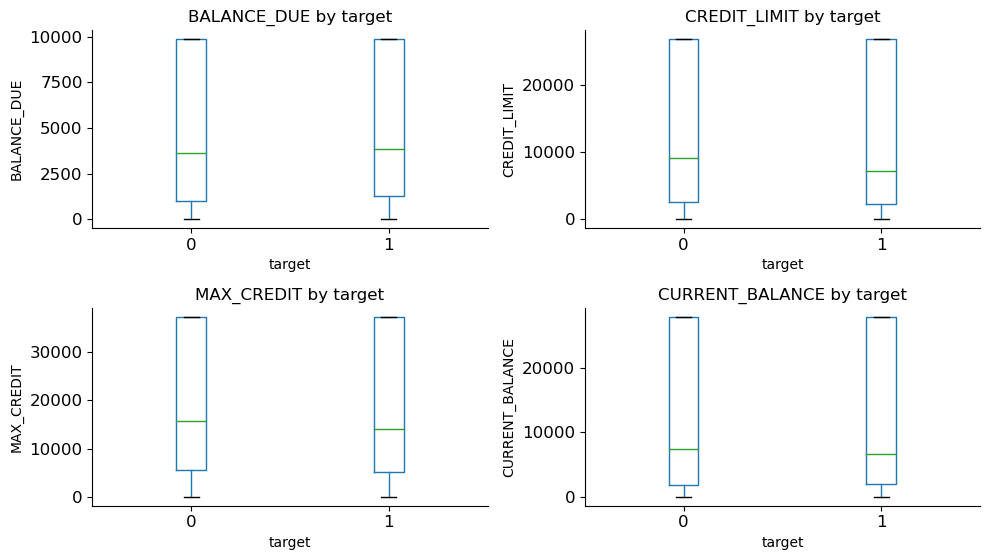

In [22]:
plot_panel(df_total, credit_variables, 2,2, plot_type="box", y_var='target', figsize=(10,6))

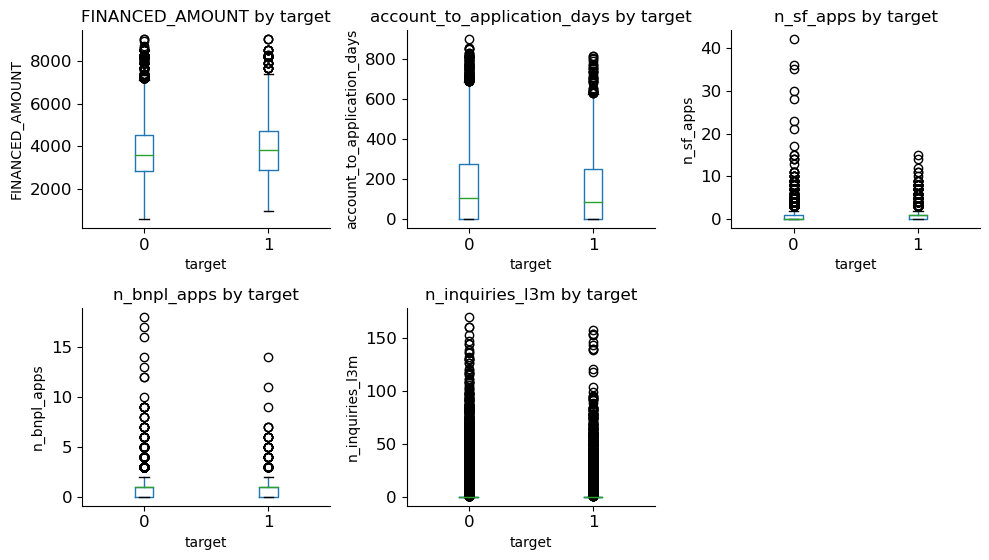

In [20]:
plot_panel(df_total, numericas, 2,3, plot_type="box", y_var='target', figsize=(10,6))